# Chronic Absenteeism Rate Prediction (CARP) Data Exploration (EXP)

### Make preparations specific to IBM Watson Studio: add libraries missing from kernel, import project utilities, define function to download project assets

In [1]:
# Install packages for working with spatial data 
!pip install geopandas # adds spatial datatypes to pandas dataframes
!pip install descartes # helps map spatial data

     |████████████████████████████████| 921kB 20.5MB/s eta 0:00:01
     |████████████████████████████████| 11.8MB 23.1MB/s eta 0:00:01
     |████████████████████████████████| 10.1MB 27.2MB/s eta 0:00:01
     |████████████████████████████████| 1.5MB 48.4MB/s eta 0:00:01


In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
# function to retrieve project assets 
def download(project_file_name,project=None):    
    # get the file
    print("Attempting to get file {}".format(project_file_name))
    _bytes = project.get_file(project_file_name).read()
    
    # download the file
    print("Downloading...")
    
    with open(project_file_name, 'wb') as f: 
        f.write(bytearray(_bytes))
        print("Completed writing out file")
        
    return 0

### Import required modules

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import descartes
from zipfile import ZipFile
import re

### Download chronic absenteeism dataset and recreate chronic absenteeism dataframe created with CARP-ETL notebook

In [5]:
abs_file_name = 'la_county_2018_chronic_absence_rates_with_predictor_variables.csv'
download(abs_file_name,project)
abs_18 = pd.read_csv(abs_file_name, index_col='Tract')
abs_18.head()
abs_18.shape

Attempting to get file la_county_2018_chronic_absence_rates_with_predictor_variables.csv
Downloading...
Completed writing out file


(2158, 44)

### Download and visualize data quality assessment results dataset created with CARP-ETL notebook

Attempting to get file valid_pct.csv
Downloading...
Completed writing out file


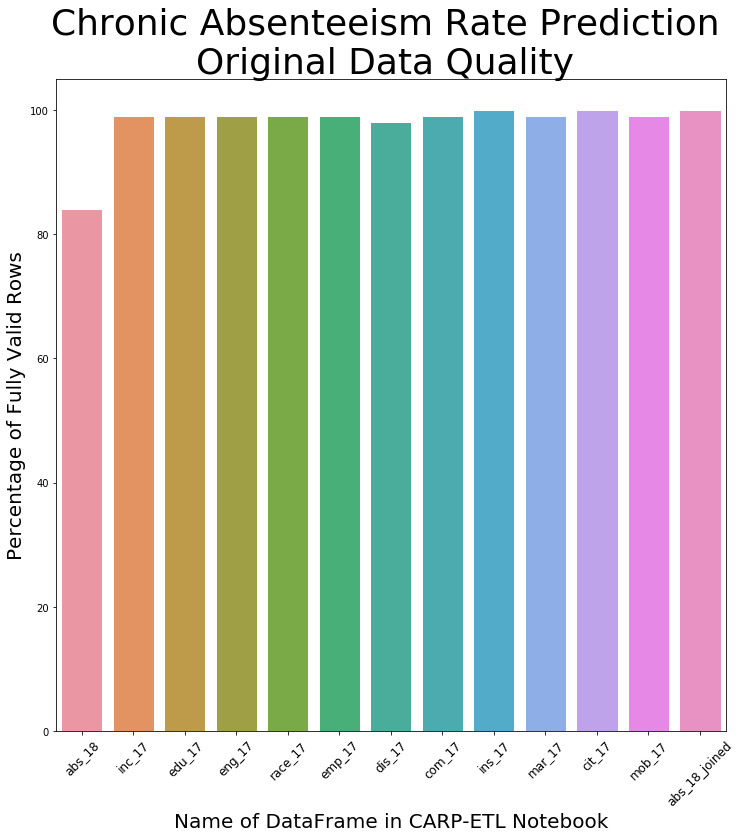

In [6]:
valid_pct_file_name = 'valid_pct.csv'
download(valid_pct_file_name,project)
valid_pct = pd.read_csv(valid_pct_file_name)
fig, ax = plt.subplots(figsize=(12,12))
sns.set(style="whitegrid", color_codes=True)
ax.set_title('Chronic Absenteeism Rate Prediction \nOriginal Data Quality ',fontsize=36)
ax = sns.barplot(x='DataFrame', y='Pct_Valid', data=valid_pct)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, size=12)
_ = plt.ylabel('Percentage of Fully Valid Rows',fontsize=20)
_ = plt.xlabel('Name of DataFrame in CARP-ETL Notebook',fontsize=20)

### Display chloropleth map of chronic absenteeism rates by LA County census tract

Attempting to get file tl_2018_06_tract.zip
Downloading...
Completed writing out file
Attempting to get file most_pop_la_county_cities.csv
Downloading...
Completed writing out file


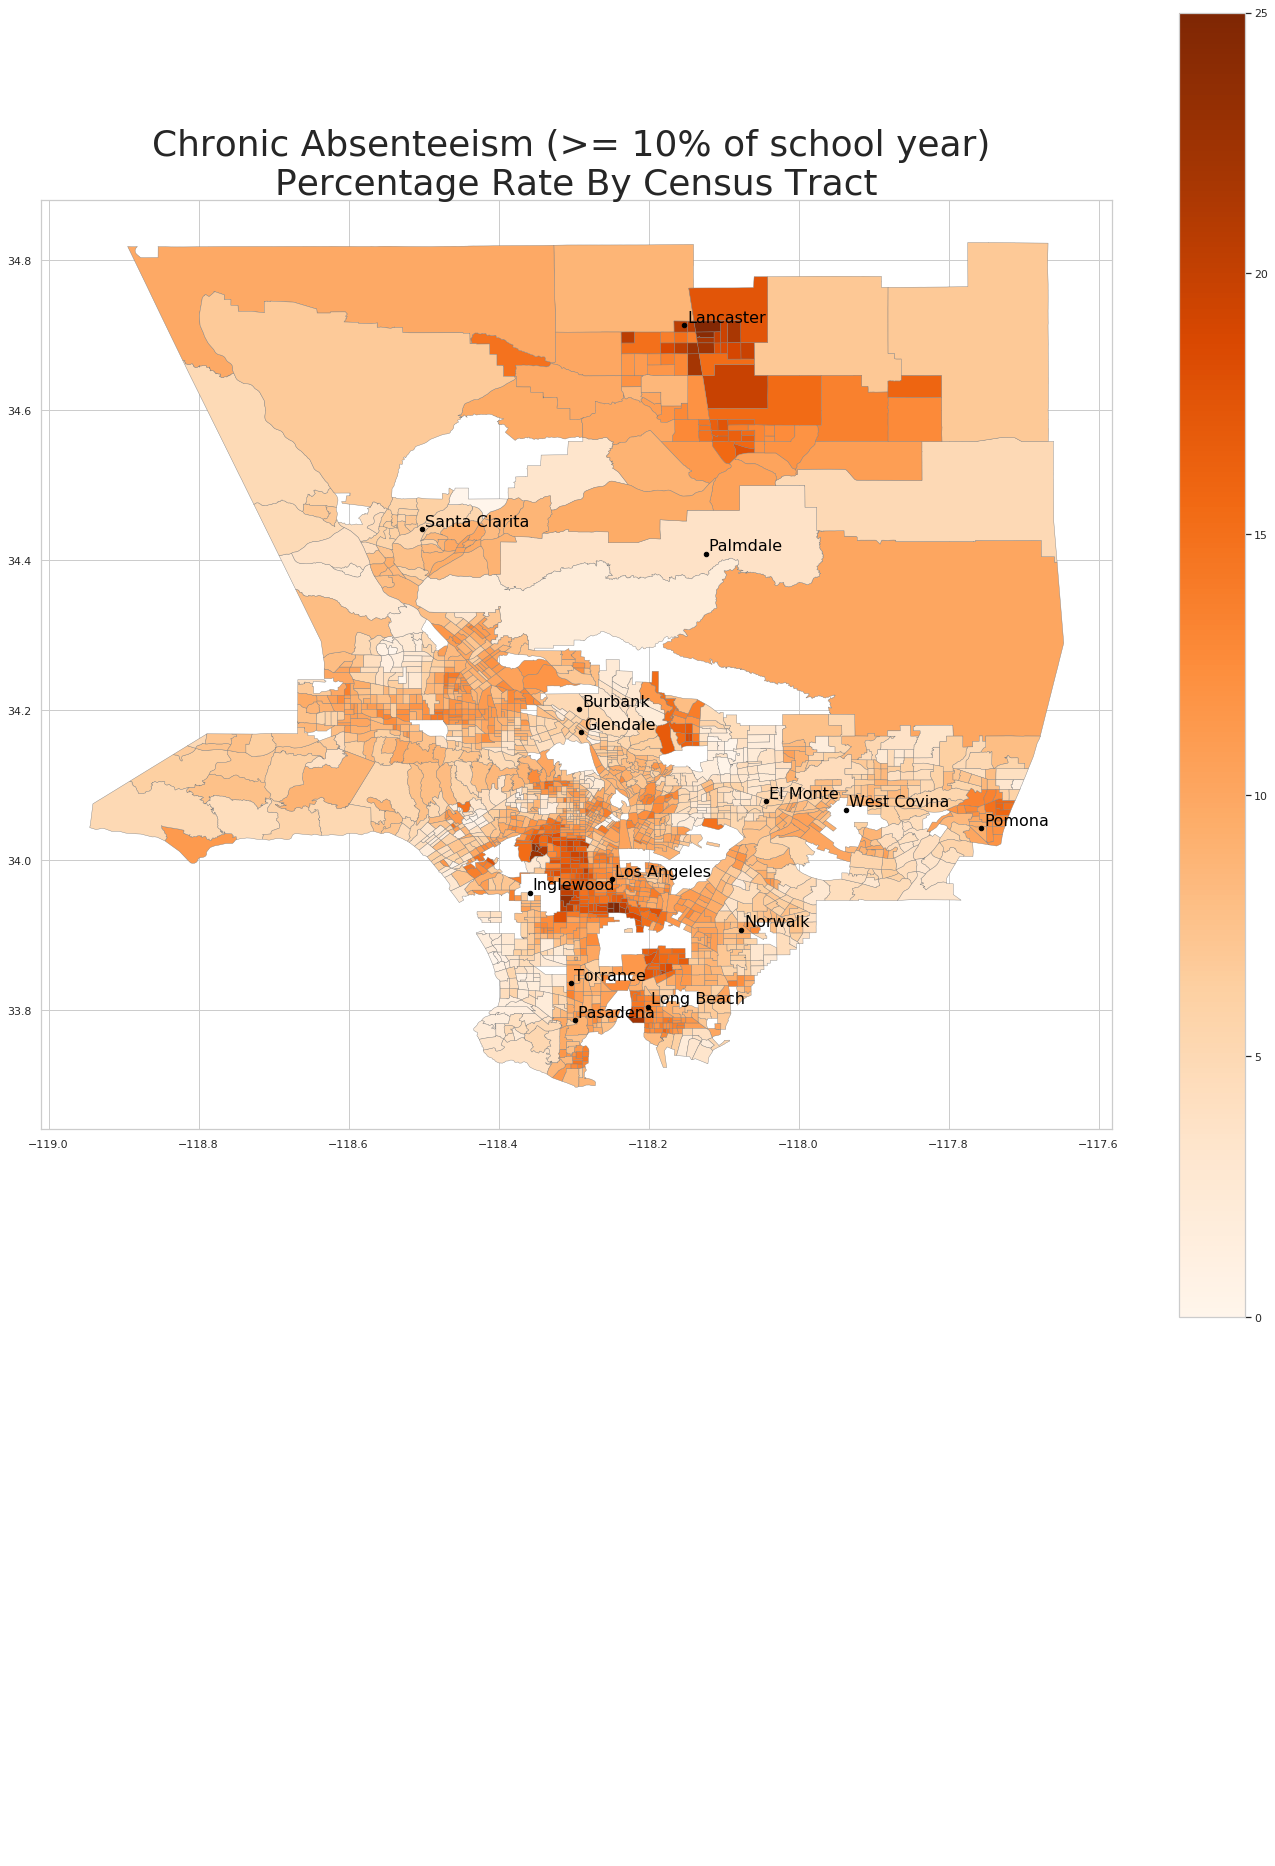

In [7]:
# Download shape file of California census tracts originally from US Census Bureau (data.census.gob)
shape_archive_name = 'tl_2018_06_tract.zip'
download(shape_archive_name, project)
with ZipFile(shape_archive_name) as fileobj:
    fileobj.extractall()
map_df=gpd.read_file('tl_2018_06_tract.shp')

# Download geocoded list of 15 largest LA County cities by population and generate GeoDataFrame
city_file_name = 'most_pop_la_county_cities.csv'
download(city_file_name,project)
city_df = pd.read_csv(city_file_name)
city_gdf = gpd.GeoDataFrame(city_df, geometry=gpd.points_from_xy(city_df.Longitude, city_df.Latitude))

#filter out outlying census tracts not part of mainland county
fil_df = map_df.cx[:-117.5, 33.6:36] 

# Merge census tract map and chronic absenteeism data 
geo_df = fil_df[['TRACTCE','geometry']]
geo_df.columns=['Tract','geometry']
abs_pct_df = abs_18[['Percent']].copy()
abs_pct_df.reset_index(inplace=True)
abs_pct_df.Tract=abs_pct_df.Tract.astype(str)
geo_df = geo_df.merge(abs_pct_df,on='Tract')

fig, ax = plt.subplots(1, figsize=(24, 24))
#ax.axis('off')
ax.set_title('Chronic Absenteeism (>= 10% of school year) \nPercentage Rate By Census Tract', fontsize=36)

ax.annotate('Source: California Department of Education, 2019',
           xy=(-118.975, 32.7),
           horizontalalignment='left', verticalalignment='top',
           fontsize=24, color='#555555')


# Plot chloropleth map
geo_df.plot(column='Percent', cmap='Oranges', linewidth=0.4, ax=ax, edgecolor='grey')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Oranges', norm=plt.Normalize(vmin=0, vmax=25))
sm._A = []
cbar = fig.colorbar(sm)

# Add major cities to map
city_gdf.plot(ax=ax,c='black',markersize=20)
for x, y, label in zip(city_gdf.geometry.x, city_gdf.geometry.y, city_gdf.City):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=16, color='black')
    
# Save the figure as a high-res png. you can also save as svg
fig.savefig('absmap.png', dpi=300)

### Display histogram of chronic absenteeism rates by LA County census tract

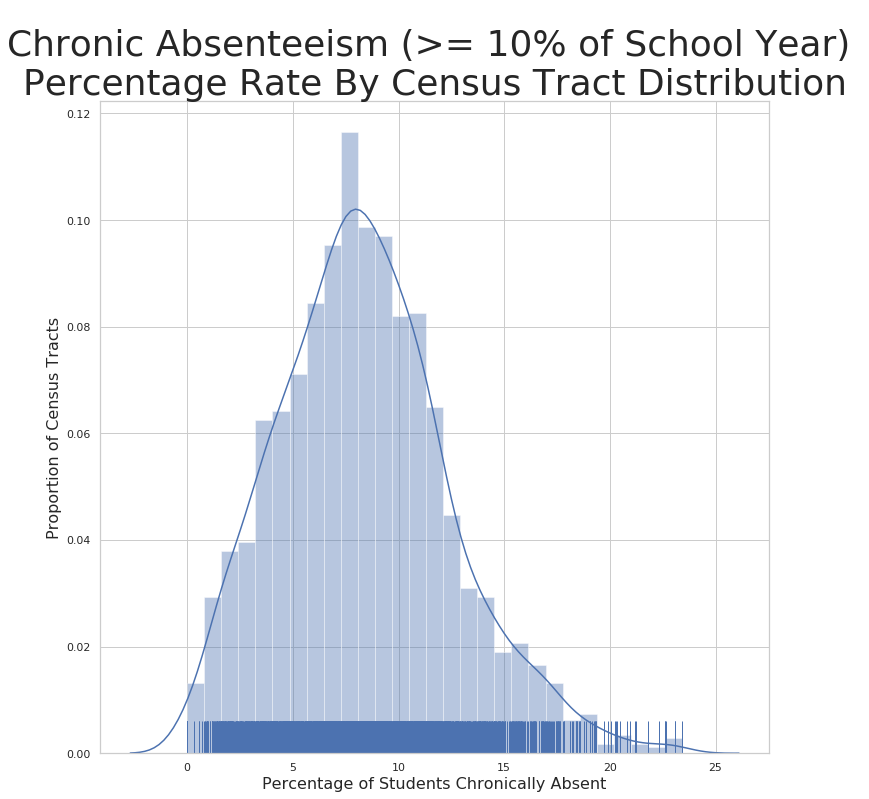

In [8]:
fig, ax = plt.subplots(figsize=(12,12))
sns.set(style="ticks", color_codes=True, font_scale=2.5)
ax=sns.distplot(abs_18.Percent, ax=ax, kde=True, rug=True)
ax.set_title('Chronic Absenteeism (>= 10% of School Year) \nPercentage Rate By Census Tract Distribution',fontsize=36)
_ = ax.annotate('Source: California Department of Education, 2019',
           xy=(0, 0.14),
           horizontalalignment='left', verticalalignment='top',
           fontsize=16, color='#555555')

_ = plt.xlabel('Percentage of Students Chronically Absent',fontsize=16)
_ = plt.ylabel('Proportion of Census Tracts',fontsize=16)

### Define function to identify top correlates of chronic absenteeism percentage

In [9]:
def top_corr(abs_df, nbr_correlates=5):
    return list(abs_df.corr().Percent.drop(['Percent', 'Count', 'Year']).pow(2)      # Squaring Pearson correlation coefficient (-1 < r < 1) to get  
                .sort_values(ascending=False).reset_index().iloc[:nbr_correlates,0])
top_corr_cols = top_corr(abs_18)

### Plot top correlates 

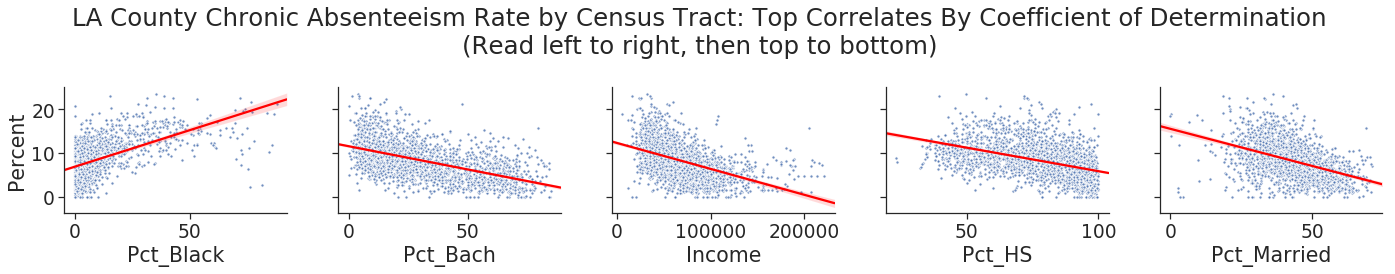

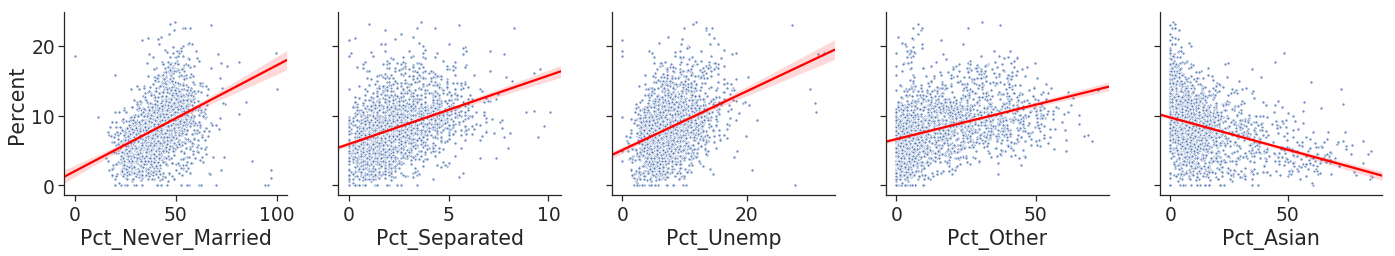

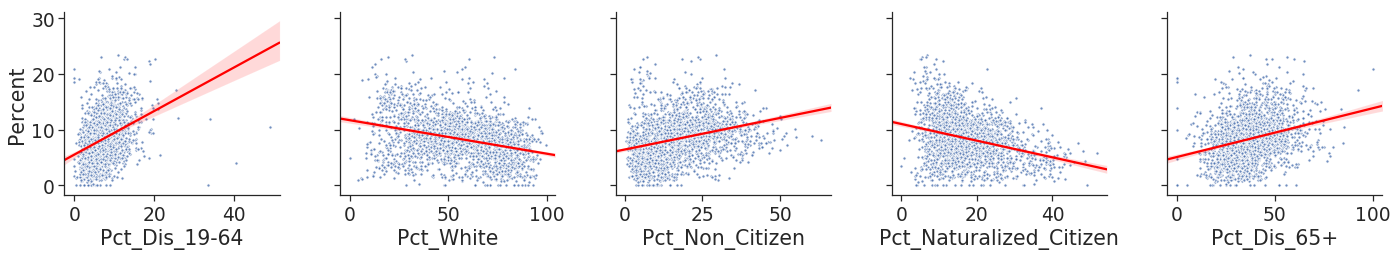

In [10]:
first_row = True
top_corrs =top_corr(abs_18,15)
sns.set(style="ticks", color_codes=True, font_scale=1.7)
for x_vars in [top_corrs[:5],top_corrs[5:10],top_corrs[10:15]]:
    g = sns.pairplot(abs_18, y_vars=['Percent'], x_vars=x_vars, kind="reg", height=4, aspect=1, plot_kws=dict(scatter_kws=dict(s=10,edgecolor='w'),line_kws=dict(color='red')))
    if first_row:
        _ = g.fig.suptitle(f"LA County Chronic Absenteeism Rate by Census Tract: Top Correlates By Coefficient of Determination\n(Read left to right, then top to bottom)")
        _ = g.fig.subplots_adjust(top = 0.7)
        first_row = False

### Save ranked correlates to object storage as project asset

In [11]:
ranked_correlates_file_name = 'ranked_correlates.csv'
ranked_corr_csv_data = pd.Series(top_corr(abs_18, -1)).to_csv(header=False,index=False)
project.save_data(ranked_correlates_file_name, ranked_corr_csv_data, set_project_asset=True, overwrite=True)

{'file_name': 'ranked_correlates.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'iverpyspark-donotdelete-pr-ysp8udweullapt',
 'asset_id': '8be8fd3c-29b3-4fc5-802f-1d70177488f4'}